In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np

import io
import os
import requests
import shapely
import json
import urllib

import geopandas as gpd
from fiona.crs import from_epsg

import scipy as sp
from scipy import stats
from scipy import ndimage

import pylab as pl
import matplotlib.pylab as plt

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. process datasets

## 1.1 zipcode shpfie

In [2]:
url = "https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip"
urllib.request.urlretrieve(url, "zipcode_file.gz")
!mkdir $PUIDATA/zipcode
!unzip -o zipcode_file.gz -d $PUIDATA/zipcode

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/zipcode’: File exists
Archive:  zipcode_file.gz
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shx  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.dbf  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.prj  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.sbn  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.sbx  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shp  
  inflating: /nfshome/jc9033/PUIdata/zipcode/ZIP_CODE_040114.shp.xml  


In [3]:
zipcode = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/zipcode/ZIP_CODE_040114.shp")
zipcode = zipcode[zipcode['COUNTY'] == 'New York']
zipcode = zipcode[['ZIPCODE', 'POPULATION', 'AREA', 'geometry']]
zipcode.crs = from_epsg(2263)
#zipcode.crs = from_epsg(4326)
#zipcode.crs = zipcode.to_crs(epsg=2263) 
print(zipcode.shape)
zipcode.head(3)

(112, 4)


,ZIPCODE,POPULATION,AREA,geometry
19,10463,70641.0,3.119702e+06,"POLYGON ((1007634.817063555 258290.334846884, ..."
21,10034,39149.0,2.450389e+07,"POLYGON ((1006203.169008225 257345.6566181332,..."
22,10033,54284.0,1.615605e+07,"POLYGON ((1003020.86467731 256049.1618358046, ..."


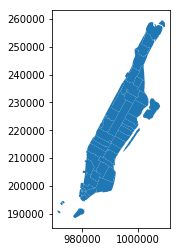

In [4]:
zipcode.plot()

## 1.2 POI shpfile

In [5]:
url = "https://data.cityofnewyork.us/api/geospatial/rxuy-2muj?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "POI_file.gz")
!mkdir $PUIDATA/POI
!unzip -d $PUIDATA/POI POI_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/POI’: File exists
Archive:  POI_file.gz
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_1f790dcc-8917-44de-b428-9936e182e8a9.dbf  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_1f790dcc-8917-44de-b428-9936e182e8a9.shp  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_1f790dcc-8917-44de-b428-9936e182e8a9.shx  
  inflating: /nfshome/jc9033/PUIdata/POI/geo_export_1f790dcc-8917-44de-b428-9936e182e8a9.prj  


In [6]:
POI = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/POI/geo_export_87f05754-f29b-4dc2-a82d-5c9479f324f2.shp")
POI.crs = from_epsg(4326)
POI = POI.to_crs(epsg=2263)
POI = POI[['borough','geometry']]
POI.dropna(inplace=True)
POI['borough'] = POI['borough'].astype(int)
POI = POI[POI['borough'] == 1]
POI.columns = ['POI_borough','geometry']
print(POI.shape)
POI.head(3)

(5777, 2)


,POI_borough,geometry
22,1,POINT (989104.3522338871 226715.9110106869)
24,1,POINT (1002439.031799316 240947.530395451)
25,1,POINT (991170.0405883786 201159.453613225)


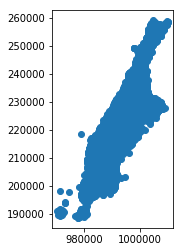

In [7]:
POI.plot()

## 1.3 Subway station shpfile

In [8]:
url = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "subway_file.gz")
!mkdir $PUIDATA/subway
!unzip -d $PUIDATA/subway subway_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/subway’: File exists
Archive:  subway_file.gz
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1621b553-928c-49d1-956e-ddbb7c9cce69.dbf  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1621b553-928c-49d1-956e-ddbb7c9cce69.shp  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1621b553-928c-49d1-956e-ddbb7c9cce69.shx  
  inflating: /nfshome/jc9033/PUIdata/subway/geo_export_1621b553-928c-49d1-956e-ddbb7c9cce69.prj  


In [9]:
subway = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/subway/geo_export_539576af-15f9-411d-9278-96f70d266f16.shp")
subway = subway[['geometry','objectid']]
subway.columns = ['geometry','subway_id']
subway.crs = from_epsg(4326)
subway = subway.to_crs(epsg=2263)
print(subway.shape)
subway.head(3)

(473, 2)


,geometry,subway_id
0,POINT (986725.0019278985 205255.0527942391),1.0
1,POINT (984196.5000951464 201155.8398640769),2.0
2,POINT (988724.2161053148 216795.1908031626),3.0


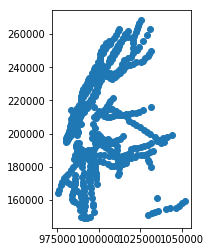

In [10]:
subway.plot()

In [11]:
subway = gpd.sjoin(subway, zipcode, how="inner")[['geometry', 'subway_id']]
print(subway.shape)
subway.head(3)

(152, 2)


,geometry,subway_id
0,POINT (986725.0019278985 205255.0527942391),1.0
104,POINT (987034.9461898913 206937.932958669),105.0
370,POINT (987039.020328727 202831.4349380784),371.0


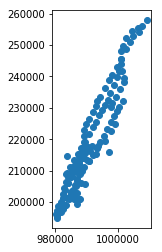

In [12]:
subway.plot()

## 1.4 Bus station shpfile

In [13]:
url = "https://data.cityofnewyork.us/api/geospatial/qafz-7myz?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "bus_file.gz")
!mkdir $PUIDATA/bus
!unzip -d $PUIDATA/bus bus_file.gz

mkdir: cannot create directory ‘/nfshome/jc9033/PUIdata/bus’: File exists
Archive:  bus_file.gz
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_18f3d4ff-f72e-41e8-a047-9c6c36eaeb7a.dbf  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_18f3d4ff-f72e-41e8-a047-9c6c36eaeb7a.shp  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_18f3d4ff-f72e-41e8-a047-9c6c36eaeb7a.shx  
  inflating: /nfshome/jc9033/PUIdata/bus/geo_export_18f3d4ff-f72e-41e8-a047-9c6c36eaeb7a.prj  


In [14]:
bus = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/bus/geo_export_85792e91-7386-4102-9317-caa2249ff1eb.shp")
bus = bus[['asset_id', 'geometry']]
bus.columns = ['bus_id', 'geometry']
bus.crs = from_epsg(4326)
bus = bus.to_crs(epsg=2263)
print(bus.shape)
bus.head(3)

(3428, 2)


,bus_id,geometry
0,1.0,POINT (998713.9845957432 196791.4612668745)
1,2.0,POINT (999451.1694101784 201267.7107736471)
2,3.0,POINT (999282.6626072562 195394.2365739072)


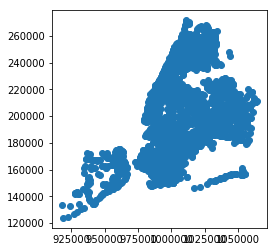

In [15]:
bus.plot()

In [16]:
bus = gpd.sjoin(bus, zipcode, how="inner")[['geometry', 'bus_id']]
print(bus.shape)
bus.head(3)

(755, 2)


,geometry,bus_id
903,POINT (987048.9820783393 207785.7335819595),904.0
1563,POINT (986159.9966711717 207305.0940948088),1564.0
1564,POINT (987714.2675982895 206518.31025707),1565.0


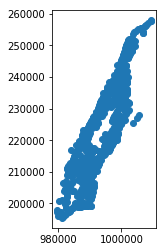

In [17]:
bus.plot()

## 1.5 Generate all traffic station points

In [18]:
TrafficStation = bus.drop('bus_id',axis=1).append(subway.drop('subway_id',axis=1)).reset_index().rename(columns={'index':'TrafficStation'})
print(TrafficStation.shape)
TrafficStation.head()

(907, 2)


,TrafficStation,geometry
0,903,POINT (987048.9820783393 207785.7335819595)
1,1563,POINT (986159.9966711717 207305.0940948088)
2,1564,POINT (987714.2675982895 206518.31025707)
3,1664,POINT (986602.7137353685 203035.5358111775)
4,1748,POINT (987327.1198019211 204183.6237035487)


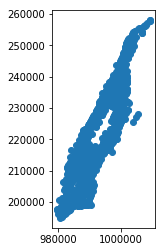

In [19]:
TrafficStation.plot()

# 2. Sjoin

In [20]:
print(POI.shape)
print(subway.shape)
print(bus.shape)
print(zipcode.shape)

(5777, 2)
(152, 2)
(755, 2)
(112, 4)


In [21]:
sjoin_POI = gpd.sjoin(zipcode, POI, how="left")[['ZIPCODE','POI_borough']].groupby("ZIPCODE").count()
sjoin_POI = sjoin_POI.reset_index()
print(sjoin_POI.POI_borough.sum())
print(sjoin_POI.shape)
sjoin_POI.head()

5645
(106, 2)


,ZIPCODE,POI_borough
0,00083,213
1,10001,118
2,10002,297
3,10003,205
4,10004,70


In [22]:
sjoin_subway = gpd.sjoin(zipcode, subway, how="left")[['ZIPCODE','subway_id']].groupby("ZIPCODE").count()
sjoin_subway = sjoin_subway.reset_index()
print(sjoin_subway.subway_id.sum())
print(sjoin_subway.shape)
sjoin_subway.head()

152
(106, 2)


,ZIPCODE,subway_id
0,00083,6
1,10001,7
2,10002,5
3,10003,7
4,10004,3


In [23]:
sjoin_bus = gpd.sjoin(zipcode, bus, how="left")[['ZIPCODE','bus_id']].groupby("ZIPCODE").count()
sjoin_bus = sjoin_bus.reset_index()
print(sjoin_bus.bus_id.sum())
print(sjoin_bus.shape)
sjoin_bus.head()

759
(106, 2)


,ZIPCODE,bus_id
0,00083,0
1,10001,19
2,10002,33
3,10003,15
4,10004,3


In [24]:
zipcode = pd.merge(zipcode, sjoin_POI, on='ZIPCODE')
zipcode = pd.merge(zipcode, sjoin_subway, on='ZIPCODE')
zipcode = pd.merge(zipcode, sjoin_bus, on='ZIPCODE')

zipcode.rename(columns={'POI_borough':'POI', 'subway_id': 'subway', 'bus_id':'bus'}, inplace=True)

zipcode['TrafficStation'] = zipcode['subway'] + zipcode['bus']
zipcode.head()

,ZIPCODE,POPULATION,AREA,geometry,POI,subway,bus,TrafficStation
0,10463,70641.0,3.119702e+06,"POLYGON ((1007634.817063555 258290.334846884, ...",15,1,3,4
1,10034,39149.0,2.450389e+07,"POLYGON ((1006203.169008225 257345.6566181332,...",117,3,15,18
2,10033,54284.0,1.615605e+07,"POLYGON ((1003020.86467731 256049.1618358046, ...",88,3,15,18
3,10040,41033.0,1.634074e+07,"POLYGON ((1002564.135275811 253724.7731118798,...",100,4,16,20
4,10032,57606.0,2.315957e+07,"POLYGON ((998935.8528342247 249154.259943217, ...",149,5,35,40


## Density Calculation

In [25]:
zipcode['POI'] = zipcode['POI']/zipcode['AREA'] * 1e6
zipcode['subway'] = zipcode['subway']/zipcode['AREA'] * 1e6
zipcode['bus'] = zipcode['bus']/zipcode['AREA'] * 1e6
zipcode['TrafficStation'] = zipcode['TrafficStation']/zipcode['AREA'] * 1e6
zipcode.head()

,ZIPCODE,POPULATION,AREA,geometry,POI,subway,bus,TrafficStation
0,10463,70641.0,3.119702e+06,"POLYGON ((1007634.817063555 258290.334846884, ...",4.808152,0.320543,0.961630,1.282174
1,10034,39149.0,2.450389e+07,"POLYGON ((1006203.169008225 257345.6566181332,...",4.774752,0.122430,0.612148,0.734577
2,10033,54284.0,1.615605e+07,"POLYGON ((1003020.86467731 256049.1618358046, ...",5.446875,0.185689,0.928445,1.114133
3,10040,41033.0,1.634074e+07,"POLYGON ((1002564.135275811 253724.7731118798,...",6.119673,0.244787,0.979148,1.223935
4,10032,57606.0,2.315957e+07,"POLYGON ((998935.8528342247 249154.259943217, ...",6.433627,0.215894,1.511255,1.727148


# 3. Heatmap

In [26]:
# refer to http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
        
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

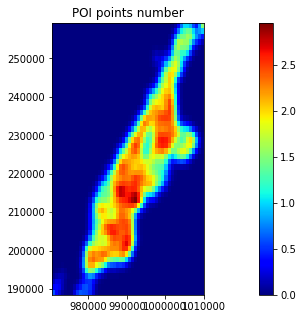

In [27]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("POI points number")
heatmap(POI, bins=50, smoothing=1)

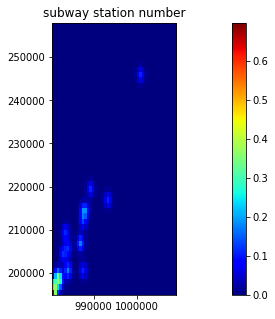

In [28]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("subway station number")
heatmap(subway, bins=50, smoothing=1)

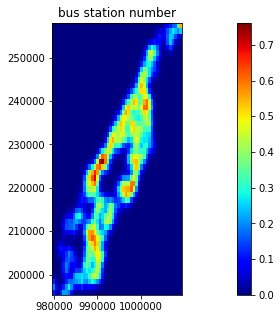

In [29]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("bus station number")
heatmap(bus, bins=50, smoothing=1)

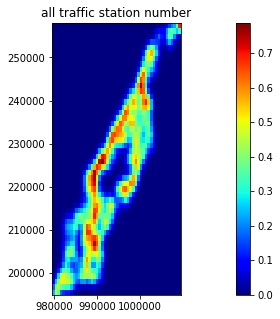

In [30]:
fig = pl.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax1.set_title("all traffic station number")
heatmap(TrafficStation, bins=50, smoothing=1)

# 4. Choropleth maps

(969193.1559385045, 1011861.583035858, 184889.21821436362, 263166.540957316)

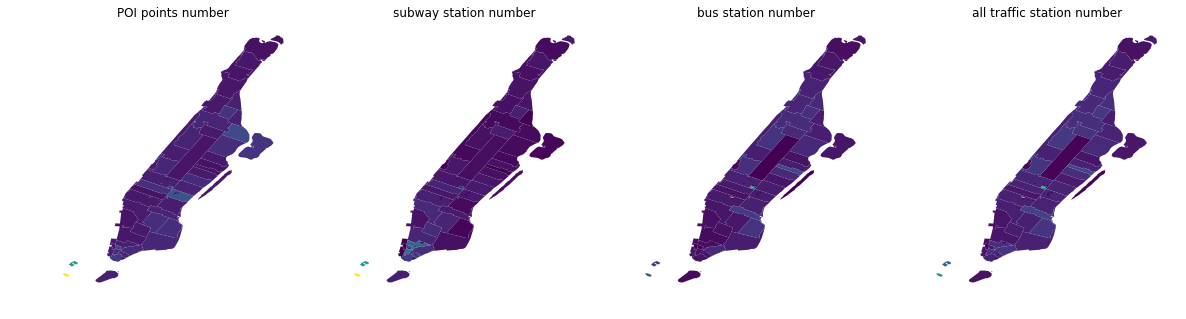

In [31]:
fig = pl.figure(figsize=(20,5))

ax1 = fig.add_subplot(141)
zipcode.plot(column='POI', ax=ax1, label=True)
ax1.set_title("POI points number")
ax1.axis('off')

ax2 = fig.add_subplot(142)
zipcode.plot(column='subway', ax=ax2, label=True)
ax2.set_title("subway station number")
ax2.axis('off')

ax3 = fig.add_subplot(143)
zipcode.plot(column='bus', ax=ax3, label=True)
ax3.set_title("bus station number")
ax3.axis('off')

ax4 = fig.add_subplot(144)
zipcode.plot(column='TrafficStation', ax=ax4, label=True)
ax4.set_title("all traffic station number")
ax4.axis('off')

# Assess if any of these distributions are consistent with a Gaussian.

## Significance threshold : alpha = 0.05

In [32]:
alpha = 0.05

## declaring the null hypothesis
Null Hypothesis: the vairiable sample for all 4 features (POI points number, subway station number, bus station number, and all traffic station number) is drawn from a Gaussian distribution, p-value 0.05

## testing

### KS test (the data has to be standardized)

In [33]:
def kstestprint(testdata, alpha):
    p = sp.stats.kstest((testdata - testdata.mean())/testdata.std(), "norm")[1]
    if p > alpha:
        print("p=%d,"%p, " the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected by KS test")
    else: 
        print("p=%d,"%p, " we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha, "by KS test")
    print()

In [34]:
print ("POI points number:")
kstestprint(zipcode.POI ,alpha)

print ("subway station number:")
kstestprint(zipcode.subway ,alpha)

print ("bus station number:")
kstestprint(zipcode.bus ,alpha)

print ("all traffic station number:")
kstestprint(zipcode.TrafficStation ,alpha)

POI points number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

subway station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

bus station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test

all traffic station number:
p=0,  we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by KS test



**Conclusion:** We can see statistical significant differences between the distribution and Gaussian distributions based on a KS test.

### AD test

In [35]:
def adtestprint(testdata, alpha):
    ad = sp.stats.anderson(testdata, "norm")
    if ad[0] < ad[1][ad[2] == int(alpha * 100)]:
        print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected by AD test")
    else: 
        print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha, "by AD test")
    print()

In [36]:
print ("POI points number")
adtestprint(zipcode.POI, alpha)

print ("subway station number")
adtestprint(zipcode.subway, alpha)

print ("bus station number")
adtestprint(zipcode.bus, alpha)

print ("all traffic station number")
adtestprint(zipcode.TrafficStation, alpha)

POI points number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

subway station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

bus station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test

all traffic station number
we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of 0.05 by AD test



**Conclusion** We can see statistical significant differences between the distribution and Gaussian distributions based on a AD test. 

# Plot the distributions of each feature

Text(0,0.5,'Number of zipcode areas')

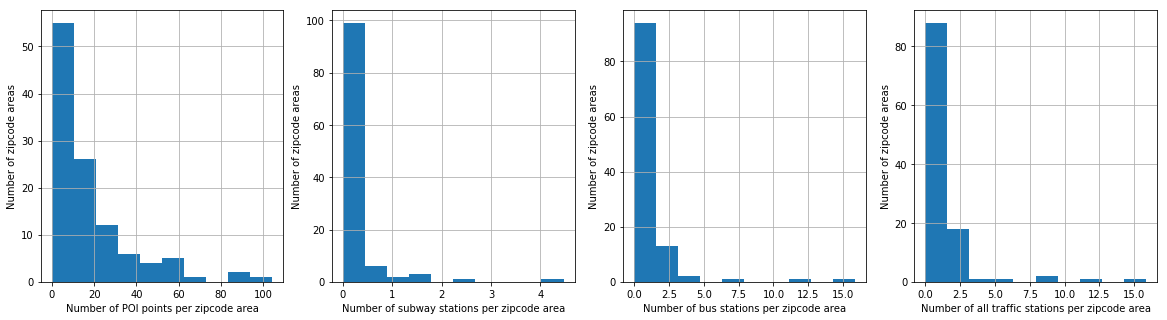

In [37]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(141)
zipcode.POI.hist(ax=ax)
ax.set_xlabel("Number of POI points per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(142)
zipcode.subway.hist(ax=ax)
ax.set_xlabel("Number of subway stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(143)
zipcode.bus.hist(ax=ax)
ax.set_xlabel("Number of bus stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

ax = fig.add_subplot(144)
zipcode.TrafficStation.hist(ax=ax)
ax.set_xlabel("Number of all traffic stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")

**Figure 5** Distribution of 4 features (POI points number, subway station number, bus station number, and all traffic station number) by zipcode in Manhattan, NY. The distribution is dominated by very low number of zipcode areas.

(0, 10)

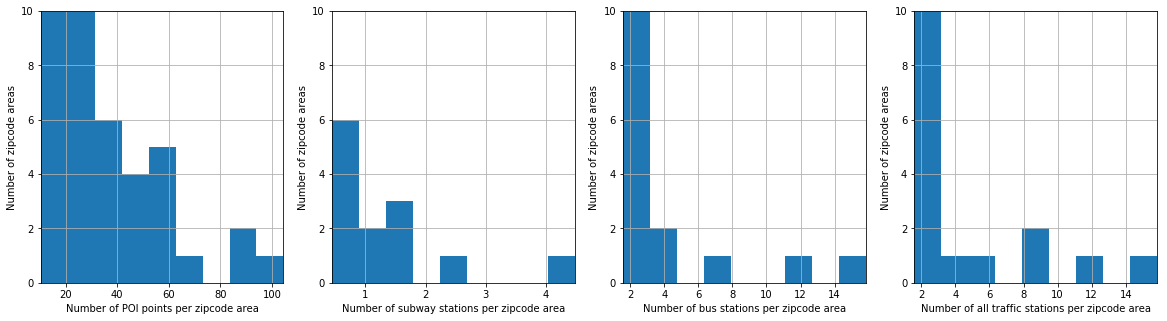

In [45]:
fig = pl.figure(figsize=(20,5))
ax = fig.add_subplot(141)
plotdata = zipcode.POI
plotdata.hist(ax=ax)
ax.set_xlabel("Number of POI points per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,10)

ax = fig.add_subplot(142)
plotdata = zipcode.subway
plotdata.hist(ax=ax)
ax.set_xlabel("Number of subway stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,10)

ax = fig.add_subplot(143)
plotdata = zipcode.bus
plotdata.hist(ax=ax)
ax.set_xlabel("Number of bus stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,10)

ax = fig.add_subplot(144)
plotdata = zipcode.TrafficStation
plotdata.hist(ax=ax)
ax.set_xlabel("Number of all traffic stations per zipcode area")
ax.set_ylabel("Number of zipcode areas")
ax.set_xlim(plotdata.max()*0.1,plotdata.max())
ax.set_ylim(0,10)

**Figure 5** Distribution of 4 features (POI points number, subway station number, bus station number, and all traffic station number) by zipcode in Manhattan, NY, low values excluded. They shows statistically consistent with Gaussians.

# Measure correlation between Number of POI points and other 3 features (subway station number, bus station number, and all traffic station number)

Returns of pearsonr:(Pearson’s correlation coefficient, 2-tailed p-value)<br>
Do not use the p-value from the pearson's or Spearman's R unless under significant assumptins.

In [39]:
sp.stats.pearsonr(zipcode.POI, zipcode.subway)

(0.31840595511384767, 0.00062302575279179876)

In [40]:
sp.stats.pearsonr(zipcode.POI, zipcode.bus)

(0.042932978688420068, 0.6530925940999821)

In [41]:
sp.stats.pearsonr(zipcode.POI, zipcode.TrafficStation)

(0.11675353750487785, 0.2202214941893596)

**conclusions** there is a weak statistical correlation between park condition and unemployment: where unemployment is higher park conditions are better, which is opposite to our original thesis, while there is no correlation with park number so that our analysis does not identifies disparities in the parks access measured as number of parks with center in a specific PUMA. 

# Test if the average number of POI points is significantly different for zipcode areas with an all traffic station number grater than  and lower then 0.05

## setting a significance threshold : alpha = 0.05

In [43]:
alpha = 0.05

## Null Hypothesis:
the null hypothesis is that the distributions of park conditions is the same at high (unemployment fraction > 0/05) and low (unemployment fraction <= 0/05)
unemployment rate come from the same parent distribution

### KS 
I do not need to standardize the distributions as I want to notice differences in the mean as well here!

In [44]:
p = sp.stats.ttest_ind(bkmerged[bkmerged.unemployedF < 0.05]['condition'].values,
                   bkmerged[bkmerged.unemployedF >= 0.05]['condition'].values)[1]
if p > alpha:
    print("the Null hypothesis that the samples are drawn from a Gaussian distribution cannot be rejected")
else: 
    print("we reject the Null hypothesis that the samples are drawn from a Gaussian distribution at a p-value of", alpha)
    

NameError: name 'bkmerged' is not defined

**conclusion ** The KS test reveals no disparities in parks maintenance with socioeconomic features (measured by unemployment fraction)

# Overall Conclusions
This analysis is largely exploratory but it did not reveal any disparities in parks access or mantanence condition of parks with our chosen socioeconomic feature of unemployment rate